# Predicting the best *Gilets Jaunes*' demonstration localization to limit material damages in Paris

## **Business Plan**

  It has been now 5 months that *Gilets Jaunes* are demonstrating in Paris. Some are pacific whereas an increasing number of "black blocs" are decimating the old neighborhoods of the town, trashing streets and buildings and specifically targetting Gastronomic Restaurants, Luxury shops and other so-called symbolic places. The global cost for France is currently above the hundred million of euros.

  In this project, we will try to identify the neighboorhods that are the most likely to be subject to vandalism and try to find neighborhoods where the manifestors could be headed over in order to avoid damage as much as possible.
  
  We believe that it can help the French Government and Paris citizens to estimate what damages could be done in case of a march. It is also essential for the *Gilets Jaunes* who are truly willing to speak their voice during a planned and government accepted-march, and want to demonstrate without the violences and degradations that had accompagnied them every Saturday.
  
  We make this project public and we know that there are plenty of other factors to take into account on this very sensitive subject. This project is just a preliminary to further analyses.

## Importations

In [1]:
import numpy as np 

import pandas as pd

import json 

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

## Data Cleaning

We will use the borough and neighborhood data to find with Foursquare the venues in each neighborhoods. For that, we need a table with the boroough, neighborhood, coordinates and venues. Let's go!

***First, you will have to download the JSON file of the Paris Neighborhoods at this address : ***

    https://opendata.paris.fr/explore/dataset/quartier_paris/export/?location=12,48.85889,2.34692&basemap=jawg.streets&dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6InF1YXJ0aWVyX3BhcmlzIiwib3B0aW9ucyI6e319LCJjaGFydHMiOlt7ImFsaWduTW9udGgiOnRydWUsInR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQVZHIiwieUF4aXMiOiJuX3NxX3F1Iiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoiIzI2Mzg5MiJ9XSwieEF4aXMiOiJuX3NxX3F1IiwibWF4cG9pbnRzIjo1MCwic29ydCI6IiJ9XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D
    
***OR you can find it on my Github repository:*** https://github.com/Smaragdy/Coursera-Project-Gilets-Jaunes
    
    
We then extract a panda dataframe from it:

In [2]:
with open('YOUR_DEPOSITORY\quartier_paris.json') as json_data:
    quartier_paris = json.load(json_data)

In [3]:
#Have a look at the data
quartier_paris[0]

{'datasetid': 'quartier_paris',
 'recordid': '9666923f5fd0b58c759554b079194bfe8289a289',
 'fields': {'n_sq_qu': 750000010,
  'perimetre': 2139.62538775,
  'objectid': 50,
  'longueur': 2139.5355911,
  'c_qu': 10,
  'surface': 271750.32393656,
  'geom_x_y': [48.86388739200148, 2.3631233009869512],
  'geom': {'type': 'Polygon',
   'coordinates': [[[2.367101341254551, 48.86162755885409],
     [2.367265176116383, 48.86094919413814],
     [2.363560968606968, 48.86147027305098],
     [2.361225279064903, 48.86179542267097],
     [2.359812353799636, 48.862601603581574],
     [2.358758689067378, 48.86315994208899],
     [2.358376790869217, 48.863331544411615],
     [2.358265473420907, 48.86336590690384],
     [2.3584034898810122, 48.86354959975191],
     [2.3588510511819463, 48.864001734507674],
     [2.359335215112276, 48.86442913978287],
     [2.359536635370187, 48.86462500317124],
     [2.35965880809718, 48.86469520766889],
     [2.359761463915734, 48.86475463241963],
     [2.360209979547445

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude','Longitude'] 

# instantiate the dataframe
neigh = pd.DataFrame(columns=column_names)

We create the dataframe

In [5]:
for data in quartier_paris:
    borough = neighborhood_name = data['fields']['c_ar']
    neighborhood_name = data['fields']['l_qu']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neigh = neigh.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neigh.head()

,Borough,Neighborhood,Latitude,Longitude
0,3,Enfants-Rouges,48.863887,2.363123
1,4,Notre-Dame,48.852896,2.352775
2,5,Jardin-des-Plantes,48.841940,2.356894
3,7,Saint-Thomas-d'Aquin,48.855263,2.325588
4,9,Faubourg-Montmartre,48.873935,2.343253


In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neigh['Borough'].unique()),
        neigh.shape[0]
    )
)

The dataframe has 20 boroughs and 80 neighborhoods.


Now that we have the coordinates associated with each neighboorhood, we will find the venues using Foursquare. Once we have the venue, we will try to cluster the neighborhoods in order to know which are the more likely to have huge damages.

***But FIRST, We will have to take into account the kind of population living in these area, who could join or not the movement, be more impacted, etc. ***

*If the dataset were easily available, it would be nice to add to this datatable the index of criminality in the different neighborhood, as well as a population kind (student, residential, ...) index.*

Instead, we will use Poverty Index and Revenues known in Paris Borough (INSEE 2015). ***Please download the file on my Github repository :***
https://github.com/Smaragdy/Coursera-Project-Gilets-Jaunes

In [8]:
Pov_df = pd.read_excel('YOUR_DEPOSITORY/file.xls',header = 4)

In [9]:
Pov_df.head()

,Code géographique,Libellé géographique,Nombre de ménages fiscaux,Nombre de personnes dans les ménages fiscaux,Médiane du niveau vie (€),Part des ménages fiscaux imposés (%),Taux de pauvreté-Ensemble (%),Taux de pauvreté-moins de 30 ans (%),Taux de pauvreté-30 à 39 ans (%),Taux de pauvreté-40 à 49 ans (%),...,"Part des pensions, retraites et rentes (%)",Part des revenus du patrimoine et autres revenus (%),Part de l'ensemble des prestations sociales (%),dont part des prestations familiales (%),dont part des minima sociaux (%),dont part des prestations logement (%),Part des impôts (%),1er décile du niveau de vie (€),9e décile du niveau de vie (€),Rapport interdécile 9e décile/1er décile
0,CODGEO,LIBGEO,NBMENFISC15,NBPERSMENFISC15,MED15,PIMP15,TP6015,TP60AGE115,TP60AGE215,TP60AGE315,...,PPEN15,PPAT15,PPSOC15,PPFAM15,PPMINI15,PPLOGT15,PIMPOT15,D115,D915,RD15
1,01001,L'Abergement-Clémenciat,308,801,22228,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01002,L'Abergement-de-Varey,100,245.5,22883.3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01004,Ambérieu-en-Bugey,6216,13917,19735.2,53.313,17.2271,19.0582,20.8566,22.5134,...,26.9,9.5,6.7,2.7,2,2,-15.8,10398.6,33801.2,3.25056
4,01005,Ambérieux-en-Dombes,624,1671.5,23182.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We only keep the information that we think are relevant

In [10]:
PRC = Pov_df[["Code géographique",'Libellé géographique',"Taux de pauvreté-Ensemble (%)","Médiane du niveau vie (€)"]]

In [11]:
PRC = PRC.drop([0], axis=0)

In [12]:
PRC.rename(columns={'Code géographique':'Borough',
                          'Libellé géographique':'Borough_name',
                          'Taux de pauvreté-Ensemble (%)':'Poverty',
                          'Médiane du niveau vie (€)':'Median_Life_level'}, 
                 inplace=True)

In [13]:
PRC.head()

,Borough,Borough_name,Poverty,Median_Life_level
1,01001,L'Abergement-Clémenciat,NaN,22228
2,01002,L'Abergement-de-Varey,NaN,22883.3
3,01004,Ambérieu-en-Bugey,17.2271,19735.2
4,01005,Ambérieux-en-Dombes,NaN,23182.7
5,01006,Ambléon,NaN,NaN


In [14]:
#PRC = PRC.drop([0], axis=0)

We will only keep the Paris Neighborhoods

In [15]:
PRCC = PRC[PRC['Borough'].str.contains('751+') == True]
PRCC.head()

,Borough,Borough_name,Poverty,Median_Life_level
1135,02751,Trucy,NaN,17915
5086,14751,Vignats,NaN,20213.3
10063,27510,Saint-Aquilin-de-Pacy,NaN,21483.3
10064,27511,Saint-Aubin-d'Écrosville,NaN,21278.7
10065,27512,Saint-Aubin-de-Scellon,NaN,20670.4


In [16]:
P = PRCC[PRCC['Borough_name'].str.contains('Paris') == True]
P

,Borough,Borough_name,Poverty,Median_Life_level
30083,75101,Paris 1er Arrondissement,11.272,31842.6
30084,75102,Paris 2e Arrondissement,14.5434,30024.5
30085,75103,Paris 3e Arrondissement,12.6436,30988
30086,75104,Paris 4e Arrondissement,11.7639,30514.7
30087,75105,Paris 5e Arrondissement,10.6787,32950
30088,75106,Paris 6e Arrondissement,9.3342,38447.7
30089,75107,Paris 7e Arrondissement,8.1007,41949
30090,75108,Paris 8e Arrondissement,9.69581,39774
30091,75109,Paris 9e Arrondissement,11.8941,32771
30092,75110,Paris 10e Arrondissement,18.4505,25154


In [17]:
Bor = list(range(1,21))

In [18]:
P['Borough'] = Bor
P = P.drop(['Borough_name'], axis=1)
P

C:\Users\Morgane Nadal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Borough,Poverty,Median_Life_level
30083,1,11.272,31842.6
30084,2,14.5434,30024.5
30085,3,12.6436,30988
30086,4,11.7639,30514.7
30087,5,10.6787,32950
30088,6,9.3342,38447.7
30089,7,8.1007,41949
30090,8,9.69581,39774
30091,9,11.8941,32771
30092,10,18.4505,25154


We add it to the first dataframe

In [19]:
Bo = list(P.iloc[:,0])
Pov = list(P.iloc[:,1])
Med = list(P.iloc[:,2])

In [20]:
L=[]
M=[]
for i in neigh['Borough']:
    for j in Bo:
        if i == j:
            L.append(Pov[j-1])
            M.append(Med[j-1])

In [21]:
neigh['Poverty'] = L
neigh['Median_Life_Level'] = M

Here is the clean dataframe

In [22]:
neigh.head()

,Borough,Neighborhood,Latitude,Longitude,Poverty,Median_Life_Level
0,3,Enfants-Rouges,48.863887,2.363123,12.643554,30988.000000
1,4,Notre-Dame,48.852896,2.352775,11.763913,30514.666667
2,5,Jardin-des-Plantes,48.841940,2.356894,10.678701,32950.000000
3,7,Saint-Thomas-d'Aquin,48.855263,2.325588,8.100699,41949.000000
4,9,Faubourg-Montmartre,48.873935,2.343253,11.894139,32771.000000


Done ! We have finished the data cleaning !

### Verification of a linearity between Poverty and Median Life Level

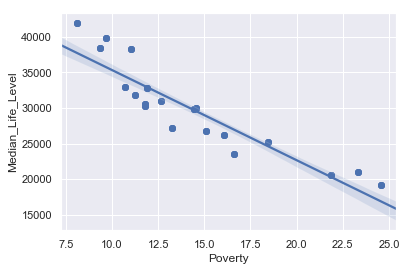

In [23]:
import seaborn as sns; sns.set(color_codes=True)
ax = sns.regplot(x="Poverty", y="Median_Life_Level", data=neigh)
ax

## Exploration of the venues in each neighborhood

#### Paris geolocalization

In [24]:
address = 'Paris, France'

geolocator2 = Nominatim(user_agent="Test")
location = geolocator2.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_paris = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# add markers to map
for lat, lng, label in zip(neigh['Latitude'], neigh['Longitude'], neigh['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.3,
        parse_html=False).add_to(map_paris)  
    
map_paris

Let's explore the first neighborhood using Foursquare :

In [25]:
#First enter your Foursquare IDs :

CLIENT_ID = 'your-client-ID' # your Foursquare ID
CLIENT_SECRET = 'your-client-secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: your-client-ID
CLIENT_SECRET:your-client-secret


In [29]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=BGXL2DSMIFI13DHVVCZFZ1OHNYIV1NWEEH1HXSEOSLXCCBS2&client_secret=2UN3RYUPEPDHLKFMS44CPATRU2AGFOZQUMRPDOHXEZHVH5SE&v=20180605&ll=48.86388739200148,2.3631233009869512&radius=500&limit=100'

In [30]:
results = requests.get(url).json()

In [31]:
results

{'meta': {'code': 200, 'requestId': '5ca50aba6a60712cf129cc78'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Enfants-Rouges',
  'headerFullLocation': 'Enfants-Rouges, Paris',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 161,
  'suggestedBounds': {'ne': {'lat': 48.86838739650148,
    'lng': 2.3699510002663455},
   'sw': {'lat': 48.85938738750148, 'lng': 2.356295601707557}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d974096a2c654814aa6d353',
       'name': 'Mmmozza',
       'location': {'address': '57 rue de Bretagne',
        'lat': 48.86391016055883,
        'lng': 2.360590696334839,
        'labeledLatLngs': [{'label': 'display',
          'lat': 48.

In [32]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [33]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Mmmozza,Sandwich Place,48.863910,2.360591
1,Le Barav,Wine Bar,48.865166,2.363155
2,L'Îlot,Seafood Restaurant,48.864666,2.363317
3,Square du Temple,Park,48.864475,2.360816
4,Marché des Enfants Rouges,Farmers Market,48.862806,2.361996


In [34]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


Now let's do it for all neighborhoods

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
paris_venues = getNearbyVenues(names=neigh['Neighborhood'],
                                   latitudes=neigh['Latitude'],
                                   longitudes=neigh['Longitude'])

Enfants-Rouges
Notre-Dame
Jardin-des-Plantes
Saint-Thomas-d'Aquin
Faubourg-Montmartre
Rochechouart
Porte-Saint-Denis
Porte-Saint-Martin
Sainte-Marguerite
Bercy
St-Germain-l'Auxerrois
Combat
Ternes
Epinettes
Sainte-Avoie
Monnaie
Notre-Dame-des-Champs
Ecole-Militaire
Saint-Georges
Picpus
Maison-Blanche
Parc-de-Montsouris
Plaisance
Palais-Royal
Pont-de-Flandre
Javel 15Art
Muette
Chaillot
Mail
Archives
Arsenal
Champs-Elysées
Chaussée-d'Antin
Saint-Vincent-de-Paul
Hôpital-Saint-Louis
Petit-Montrouge
Necker
Charonne
Porte-Dauphine
Plaine de Monceaux
Batignolles
Bonne-Nouvelle
Arts-et-Metiers
Saint-Merri
Saint-Gervais
Saint-Victor
Sorbonne
Odeon
Folie-Méricourt
Bel-Air
Quinze-Vingts
Salpêtrière
Saint-Lambert
Grenelle
Saint-Fargeau
Père-Lachaise
Montparnasse
Grandes-Carrières
La Chapelle
Villette
Vivienne
Val-de-Grace
Saint-Germain-des-Prés
Invalides
Gros-Caillou
Faubourg-du-Roule
Madeleine
Europe
Saint-Ambroise
Roquette
Gare
Croulebarbe
Halles
Place-Vendôme
Gaillon
Amérique
Belleville
Auteuil

In [38]:
print(paris_venues.shape)
paris_venues.head()

(5580, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Enfants-Rouges,48.863887,2.363123,Mmmozza,48.863910,2.360591,Sandwich Place
1,Enfants-Rouges,48.863887,2.363123,Le Barav,48.865166,2.363155,Wine Bar
2,Enfants-Rouges,48.863887,2.363123,L'Îlot,48.864666,2.363317,Seafood Restaurant
3,Enfants-Rouges,48.863887,2.363123,Square du Temple,48.864475,2.360816,Park
4,Enfants-Rouges,48.863887,2.363123,Marché des Enfants Rouges,48.862806,2.361996,Farmers Market


In [39]:
paris_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Amérique,13,13,13,13,13,13
Archives,100,100,100,100,100,100
Arsenal,78,78,78,78,78,78
Arts-et-Metiers,100,100,100,100,100,100
Auteuil,15,15,15,15,15,15


In [40]:
print('There are {} uniques categories.'.format(len(paris_venues['Venue Category'].unique())))

There are 305 uniques categories.


For the analysis we will use one hot encoding

In [41]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Enfants-Rouges,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Enfants-Rouges,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,Enfants-Rouges,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Enfants-Rouges,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Enfants-Rouges,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Amérique,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.000000,0.00,0.0,0.00,0.0,0.0,0.0
1,Archives,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.010000,0.00,0.0,0.01,0.0,0.0,0.0
2,Arsenal,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.012821,0.00,0.0,0.00,0.0,0.0,0.0
3,Arts-et-Metiers,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.01,...,0.0,0.0,0.03,0.040000,0.01,0.0,0.00,0.0,0.0,0.0
4,Auteuil,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.000000,0.00,0.0,0.00,0.0,0.0,0.0


Encoding of Poverty and Median Life Level

In [44]:
X1 = neigh[['Poverty']].to_numpy()
Y1 = (X1-min(X1))/(max(X1)-min(X1))

In [45]:
X2 = neigh[['Median_Life_Level']].to_numpy()
Y2 = (X2-min(X2))/(max(X2)-min(X2))

In [46]:
paris_grouped.shape

(80, 306)

What is the frequency of the most common venues in each neighborhoods ?

In [47]:
num_top_venues = 10

for hood in paris_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amérique----
               venue  freq
0  French Restaurant  0.15
1               Café  0.08
2             Bakery  0.08
3         Street Art  0.08
4        Supermarket  0.08
5               Park  0.08
6               Pool  0.08
7           Bus Stop  0.08
8              Plaza  0.08
9    Bed & Breakfast  0.08


----Archives----
                 venue  freq
0       Clothing Store  0.09
1          Art Gallery  0.08
2    French Restaurant  0.07
3             Tea Room  0.04
4          Coffee Shop  0.04
5   Italian Restaurant  0.03
6  Japanese Restaurant  0.03
7         Cocktail Bar  0.03
8         Burger Joint  0.02
9       Sandwich Place  0.02


----Arsenal----
                venue  freq
0   French Restaurant  0.17
1               Hotel  0.05
2    Tapas Restaurant  0.04
3  Italian Restaurant  0.04
4               Plaza  0.04
5  Seafood Restaurant  0.04
6           Gastropub  0.04
7              Bakery  0.04
8                 Pub  0.03
9                Park  0.03


----Arts-et-Metiers-

                  venue  freq
0           Supermarket  0.09
1                   Bar  0.09
2        Farmers Market  0.06
3                  Café  0.06
4                 Plaza  0.06
5      Asian Restaurant  0.06
6  Fast Food Restaurant  0.06
7     Convenience Store  0.03
8                Bistro  0.03
9       Thai Restaurant  0.03


----Grandes-Carrières----
                venue  freq
0   French Restaurant  0.20
1                 Bar  0.11
2               Hotel  0.05
3          Restaurant  0.05
4                Park  0.04
5  Italian Restaurant  0.04
6              Bistro  0.04
7         Pizza Place  0.04
8            Beer Bar  0.02
9       Track Stadium  0.02


----Grenelle----
                  venue  freq
0                 Hotel  0.23
1     French Restaurant  0.09
2   Japanese Restaurant  0.09
3                Bistro  0.06
4  Gym / Fitness Center  0.04
5    Italian Restaurant  0.04
6           Coffee Shop  0.04
7             Brasserie  0.04
8                Bakery  0.04
9              

               venue  freq
0              Hotel  0.21
1  French Restaurant  0.14
2                Bar  0.07
3             Bistro  0.07
4  Korean Restaurant  0.05
5      Grocery Store  0.05
6             Bakery  0.05
7               Café  0.02
8        Supermarket  0.02
9    Thai Restaurant  0.02


----Pont-de-Flandre----
                      venue  freq
0                     Hotel  0.07
1         French Restaurant  0.07
2                Restaurant  0.05
3                      Café  0.05
4          Asian Restaurant  0.05
5                 Rock Club  0.03
6  Bike Rental / Bike Share  0.03
7             Movie Theater  0.03
8              Tram Station  0.03
9      Fast Food Restaurant  0.02


----Porte-Dauphine----
                  venue  freq
0                  Café  0.17
1              Gym Pool  0.08
2  Gym / Fitness Center  0.08
3          Tennis Court  0.08
4                  Park  0.08
5         Grocery Store  0.08
6              Bus Stop  0.08
7                 Plaza  0.08
8       

                  venue  freq
0                 Hotel  0.09
1                   Bar  0.09
2                  Café  0.07
3  Fast Food Restaurant  0.05
4     French Restaurant  0.05
5                Bistro  0.03
6             Multiplex  0.03
7           Supermarket  0.03
8    Italian Restaurant  0.03
9            Food Truck  0.03


----Vivienne----
                 venue  freq
0    French Restaurant  0.16
1  Japanese Restaurant  0.08
2   Italian Restaurant  0.04
3               Bistro  0.04
4                Hotel  0.04
5             Wine Bar  0.03
6                 Café  0.02
7     Asian Restaurant  0.02
8          Salad Place  0.02
9                  Bar  0.02




Let's identify the 10 most common and put it in a dataframe with their frequency

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amérique,French Restaurant,Pool,Tram Station,Street Art,Supermarket,Bistro,Bus Stop,Café,Bed & Breakfast,Park
1,Archives,Clothing Store,Art Gallery,French Restaurant,Coffee Shop,Tea Room,Cocktail Bar,Japanese Restaurant,Italian Restaurant,Deli / Bodega,Creperie
2,Arsenal,French Restaurant,Hotel,Bakery,Italian Restaurant,Gastropub,Plaza,Seafood Restaurant,Tapas Restaurant,Historic Site,Park
3,Arts-et-Metiers,French Restaurant,Hotel,Japanese Restaurant,Italian Restaurant,Wine Bar,Bar,Coffee Shop,Cocktail Bar,Restaurant,Vietnamese Restaurant
4,Auteuil,Tennis Court,Stadium,Racecourse,Outdoors & Recreation,Office,Museum,Botanical Garden,French Restaurant,Garden,Sporting Goods Shop


In [50]:
paris_grouped.drop('Neighborhood', 1).head()

,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.00,0.000000,0.00,0.0,0.00,0.0,0.0,0.0
1,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.00,0.08,...,0.0,0.0,0.00,0.010000,0.00,0.0,0.01,0.0,0.0,0.0
2,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.00,0.012821,0.00,0.0,0.00,0.0,0.0,0.0
3,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.02,...,0.0,0.0,0.03,0.040000,0.01,0.0,0.00,0.0,0.0,0.0
4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.00,0.000000,0.00,0.0,0.00,0.0,0.0,0.0


In [51]:
paris_grouped['Poverty_Index']=Y1
paris_grouped['Median_Life_Level_Index']=Y2

In [52]:
paris_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Poverty_Index,Median_Life_Level_Index
0,Amérique,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.275993,0.519508
1,Archives,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.010000,0.00,0.0,0.01,0.0,0.0,0.0,0.222552,0.498759
2,Arsenal,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.012821,0.00,0.0,0.00,0.0,0.0,0.0,0.156622,0.605515
3,Arts-et-Metiers,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.01,...,0.03,0.040000,0.01,0.0,0.00,0.0,0.0,0.0,0.000000,1.000000
4,Auteuil,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.230464,0.597669


## Clustering

In [53]:
# set number of clusters_ High, Moderate and Low probability of damages during a demonstration
kclusters = 3

paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 1, 2, 2, 0, 0, 2, 2])

In [54]:
paris_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Poverty_Index,Median_Life_Level_Index
0,Amérique,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.275993,0.519508
1,Archives,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.010000,0.00,0.0,0.01,0.0,0.0,0.0,0.222552,0.498759
2,Arsenal,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.012821,0.00,0.0,0.00,0.0,0.0,0.0,0.156622,0.605515
3,Arts-et-Metiers,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.01,...,0.03,0.040000,0.01,0.0,0.00,0.0,0.0,0.0,0.000000,1.000000
4,Auteuil,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.230464,0.597669


In [55]:
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop(['Cluster Labels'],axis=1)

In [56]:
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = neigh

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

paris_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Poverty,Median_Life_Level,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Enfants-Rouges,48.863887,2.363123,12.643554,30988.000000,2,Art Gallery,Wine Bar,Clothing Store,Café,Bistro,Hotel,Coffee Shop,Sandwich Place,Boutique,Italian Restaurant
1,4,Notre-Dame,48.852896,2.352775,11.763913,30514.666667,2,French Restaurant,Ice Cream Shop,Japanese Restaurant,Bakery,Plaza,Historic Site,Wine Bar,Creperie,Garden,Dessert Shop
2,5,Jardin-des-Plantes,48.841940,2.356894,10.678701,32950.000000,0,French Restaurant,Hotel,Science Museum,Garden,Museum,Café,Botanical Garden,Bakery,Greek Restaurant,Tea Room
3,7,Saint-Thomas-d'Aquin,48.855263,2.325588,8.100699,41949.000000,2,French Restaurant,Hotel,Café,Italian Restaurant,Bakery,Coffee Shop,Historic Site,American Restaurant,Tailor Shop,Cheese Shop
4,9,Faubourg-Montmartre,48.873935,2.343253,11.894139,32771.000000,2,French Restaurant,Hotel,Wine Bar,Thai Restaurant,Burger Joint,Italian Restaurant,Cocktail Bar,Creperie,Bar,Pizza Place


In [57]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 0

In [58]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,Median_Life_Level,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Jardin-des-Plantes,32950.000000,0,French Restaurant,Hotel,Science Museum,Garden,Museum,Café,Botanical Garden,Bakery,Greek Restaurant,Tea Room
5,Rochechouart,32771.000000,0,French Restaurant,Hotel,Italian Restaurant,Bakery,Bistro,Coffee Shop,Vegetarian / Vegan Restaurant,Music Venue,Bar,Thai Restaurant
6,Porte-Saint-Denis,25154.000000,0,French Restaurant,Bar,Pizza Place,Coffee Shop,Bistro,Italian Restaurant,Café,Turkish Restaurant,Burger Joint,Indian Restaurant
10,St-Germain-l'Auxerrois,31842.555556,0,French Restaurant,Hotel,Café,Plaza,Historic Site,Exhibit,Cosmetics Shop,Art Museum,Bar,Coffee Shop
12,Ternes,29872.000000,0,French Restaurant,Hotel,Italian Restaurant,Bistro,Seafood Restaurant,Asian Restaurant,Pub,Restaurant,Moroccan Restaurant,Pizza Place
14,Sainte-Avoie,30988.000000,0,French Restaurant,Bakery,Cocktail Bar,Chinese Restaurant,Coffee Shop,Restaurant,Café,Garden,Burger Joint,Seafood Restaurant
25,Javel 15Art,30227.333333,0,French Restaurant,Sushi Restaurant,Bus Stop,Hotel,Japanese Restaurant,Bakery,Pizza Place,Pool,Bar,Food & Drink Shop
28,Mail,30024.500000,0,French Restaurant,Wine Bar,Cocktail Bar,Burger Joint,Bar,Bakery,Thai Restaurant,Hotel,Italian Restaurant,Indie Movie Theater
31,Champs-Elysées,39774.000000,0,French Restaurant,Hotel,Boutique,Japanese Restaurant,Italian Restaurant,Art Gallery,Clothing Store,Plaza,Steakhouse,Garden
33,Saint-Vincent-de-Paul,25154.000000,0,French Restaurant,Indian Restaurant,Hotel,Italian Restaurant,African Restaurant,Wine Shop,Hostel,Breton Restaurant,Food & Drink Shop,Sports Bar


#### Cluster 1

In [59]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,Median_Life_Level,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Combat,19136.956522,1,French Restaurant,Restaurant,Pool,Italian Restaurant,Bar,Park,Plaza,Bike Rental / Bike Share,Thai Restaurant,Beer Garden
17,Ecole-Militaire,41949.000000,1,Hotel,French Restaurant,Plaza,Diner,Bistro,Farmers Market,Café,Garden,Dessert Shop,Pastry Shop
18,Saint-Georges,32771.000000,1,Hotel,French Restaurant,Cocktail Bar,Italian Restaurant,Bar,Theater,Café,Lounge,Japanese Restaurant,Bistro
20,Maison-Blanche,23538.181818,1,Hotel,French Restaurant,Plaza,Bistro,Café,Diner,Garden,Supermarket,Bakery,Park
21,Parc-de-Montsouris,27233.000000,1,Italian Restaurant,French Restaurant,Restaurant,Bus Stop,Middle Eastern Restaurant,Café,Sushi Restaurant,Park,Theater,Gym
34,Hôpital-Saint-Louis,25154.000000,1,French Restaurant,Bar,Bistro,Restaurant,Coffee Shop,Wine Bar,Café,Italian Restaurant,Thai Restaurant,Pizza Place
42,Arts-et-Metiers,30988.000000,1,French Restaurant,Hotel,Japanese Restaurant,Italian Restaurant,Wine Bar,Bar,Coffee Shop,Cocktail Bar,Restaurant,Vietnamese Restaurant
43,Saint-Merri,30514.666667,1,French Restaurant,Art Gallery,Ice Cream Shop,Bar,Plaza,Bakery,Clothing Store,Pub,Cocktail Bar,Burger Joint
44,Saint-Gervais,30514.666667,1,French Restaurant,Hotel,Pastry Shop,Gourmet Shop,Clothing Store,Plaza,Ice Cream Shop,Wine Bar,Falafel Restaurant,Gay Bar
52,Saint-Lambert,30227.333333,1,French Restaurant,Hotel,Thai Restaurant,Café,Bakery,Supermarket,Italian Restaurant,Bookstore,Pub,Sushi Restaurant


#### Cluster 2

In [60]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Neighborhood,Median_Life_Level,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Enfants-Rouges,30988.000000,2,Art Gallery,Wine Bar,Clothing Store,Café,Bistro,Hotel,Coffee Shop,Sandwich Place,Boutique,Italian Restaurant
1,Notre-Dame,30514.666667,2,French Restaurant,Ice Cream Shop,Japanese Restaurant,Bakery,Plaza,Historic Site,Wine Bar,Creperie,Garden,Dessert Shop
3,Saint-Thomas-d'Aquin,41949.000000,2,French Restaurant,Hotel,Café,Italian Restaurant,Bakery,Coffee Shop,Historic Site,American Restaurant,Tailor Shop,Cheese Shop
4,Faubourg-Montmartre,32771.000000,2,French Restaurant,Hotel,Wine Bar,Thai Restaurant,Burger Joint,Italian Restaurant,Cocktail Bar,Creperie,Bar,Pizza Place
7,Porte-Saint-Martin,25154.000000,2,French Restaurant,Coffee Shop,Hotel,Theater,Bar,Pizza Place,Italian Restaurant,Breakfast Spot,Café,Mexican Restaurant
8,Sainte-Marguerite,26253.000000,2,French Restaurant,Bar,Hotel,Thai Restaurant,Bistro,Wine Bar,Café,Brasserie,Beer Bar,Restaurant
9,Bercy,26729.000000,2,Hotel,French Restaurant,Bakery,Wine Bar,Italian Restaurant,Museum,Gym / Fitness Center,Bus Stop,Japanese Restaurant,Bar
13,Epinettes,29872.000000,2,French Restaurant,Restaurant,Supermarket,Bar,Park,Food & Drink Shop,Bakery,Pedestrian Plaza,Sushi Restaurant,Gym / Fitness Center
15,Monnaie,38447.692308,2,French Restaurant,Hotel,Wine Bar,Bistro,Plaza,Restaurant,Seafood Restaurant,Bar,Café,Chocolate Shop
16,Notre-Dame-des-Champs,38447.692308,2,French Restaurant,Hotel,Bakery,Italian Restaurant,Japanese Restaurant,Bistro,Tea Room,Café,Pub,Bar


Let's try doing it with the label median life level, which should correlate with the luxury of shops and restaurants. Therefore a supervised algorithm could give us better results

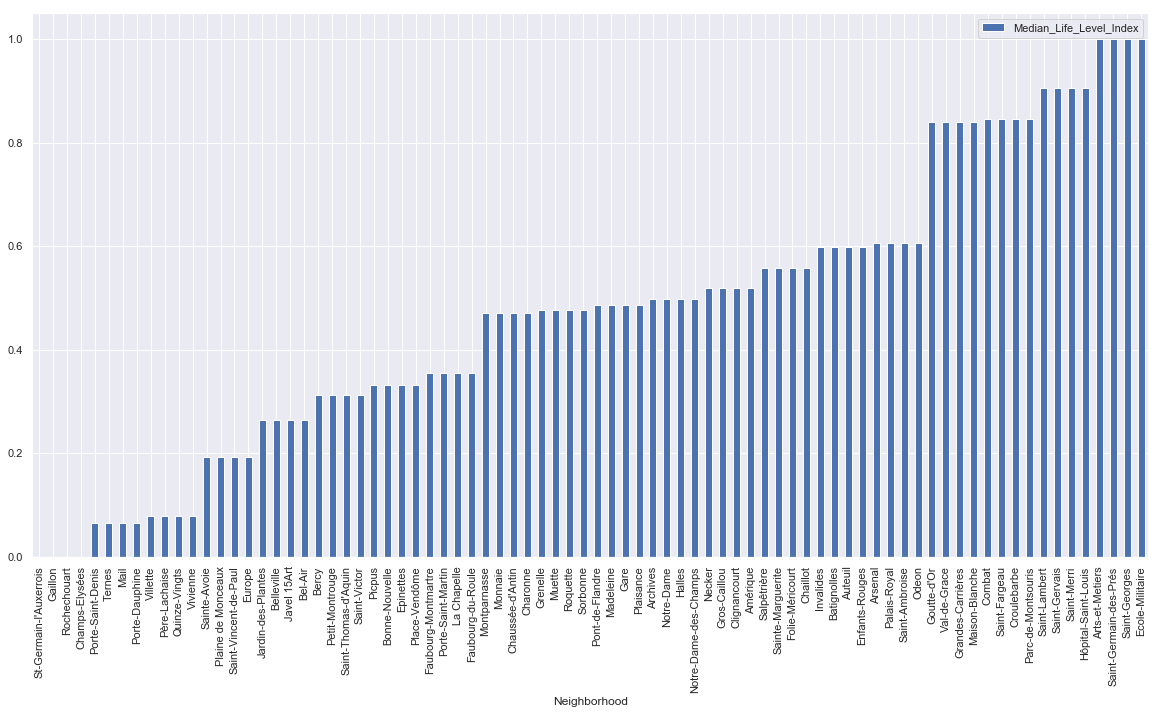

In [61]:
revenue = paris_grouped.sort_values(["Median_Life_Level_Index"],ascending = 1)
revenue.plot(x="Neighborhood",y="Median_Life_Level_Index",figsize=(20,10),use_index=True,kind='bar')

## Supervised Learning

In [62]:
X = paris_grouped.drop(["Neighborhood","Median_Life_Level_Index","Poverty_Index"],axis=1)
y = paris_grouped["Median_Life_Level_Index"]

In [63]:
y[0:5]

0    0.519508
1    0.498759
2    0.605515
3    1.000000
4    0.597669
Name: Median_Life_Level_Index, dtype: float64

In [64]:
Y = y.to_numpy()

In [65]:
Y

array([0.51950819, 0.49875892, 0.60551539, 1.        , 0.59766866,
       0.59766866, 0.26376609, 0.26376609, 0.3119424 , 0.33280857,
       0.55696891, 0.        , 0.47058667, 0.47058667, 0.51950819,
       0.84651495, 0.84651495, 1.        , 0.59766866, 0.33280857,
       0.19293428, 0.35490216, 0.35490216, 0.55696891, 0.        ,
       0.48616323, 0.8399968 , 0.8399968 , 0.47727173, 0.51950819,
       0.49875892, 0.90465563, 0.59766866, 0.26376609, 0.26376609,
       0.35490216, 0.48616323, 0.06553746, 0.8399968 , 0.47058667,
       0.47058667, 0.47727173, 0.51950819, 0.49875892, 0.49875892,
       0.60551539, 0.60551539, 0.84651495, 0.3119424 , 0.33280857,
       0.33280857, 0.19293428, 0.48616323, 0.48616323, 0.06553746,
       0.06553746, 0.35490216, 0.07912678, 0.07912678, 0.        ,
       0.47727173, 0.60551539, 0.84651495, 1.        , 1.        ,
       0.90465563, 0.90465563, 0.90465563, 0.3119424 , 0.3119424 ,
       0.19293428, 0.19293428, 0.55696891, 0.55696891, 0.47727

#### Encoding

In [66]:
Y_enc=np.zeros(len(Y))
Y_enc

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [119]:
for i in range(len(Y)):
    if Y[i] < 0.2:
        Y_enc[i] = 0
    elif Y[i] > 0.2 and Y[i] < 0.4:
        Y_enc[i]=1
    elif Y[i] > 0.4 and Y[i] < 0.65:
        Y_enc[i] = 2
    else:
        Y_enc[i] = 3


In [120]:
Y_enc

array([2., 2., 2., 3., 2., 2., 1., 1., 1., 1., 2., 0., 2., 2., 2., 3., 3.,
       3., 2., 1., 0., 1., 1., 2., 0., 2., 3., 3., 2., 2., 2., 3., 2., 1.,
       1., 1., 2., 0., 3., 2., 2., 2., 2., 2., 2., 2., 2., 3., 1., 1., 1.,
       0., 2., 2., 0., 0., 1., 0., 0., 0., 2., 2., 3., 3., 3., 3., 3., 3.,
       1., 1., 0., 0., 2., 2., 2., 0., 0., 3., 0., 0.])

In [121]:
#K-mean
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_enc, y_test_enc = train_test_split( X, Y_enc, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (64, 305) (64,)
Test set: (16, 305) (16,)


### kNN

In [123]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [124]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train_enc)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test_enc, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.1875, 0.1875, 0.1875, 0.125 , 0.1875, 0.25  , 0.1875, 0.25  ,
       0.1875])

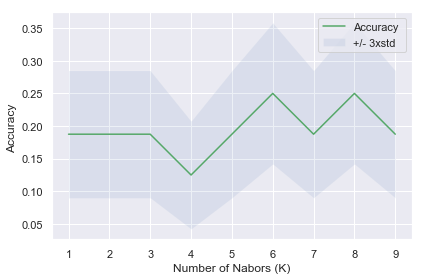

In [125]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [126]:
Kn = KNeighborsClassifier(n_neighbors = 6).fit(X_train,y_train_enc)
Kn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

In [127]:
yhat_kNN = neigh.predict(X_test)
yhat_kNN[0:5]

array([2, 0, 2, 2, 1], dtype=int64)

Comparison predicted and ground state

In [128]:
yhat_kNN,y_test_enc

(array([2, 0, 2, 2, 1, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 0], dtype=int64),
 array([0, 3, 1, 0, 1, 3, 3, 3, 2, 1, 0, 3, 0, 2, 3, 2], dtype=int64))

### Decision Trees

In [129]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

In [130]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 7)

In [131]:
tree.fit(X_train,y_train_enc)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [132]:
yhat_tree = tree.predict(X_test)

Comparison ground state and prediction

In [133]:
yhat_tree,y_test_enc

(array([2, 1, 2, 2, 3, 0, 2, 2, 2, 1, 0, 2, 2, 2, 3, 1], dtype=int64),
 array([0, 3, 1, 0, 1, 3, 3, 3, 2, 1, 0, 3, 0, 2, 3, 2], dtype=int64))

### SVM

In [134]:
from sklearn import svm
model = svm.SVC(kernel='rbf')
model.fit(X_train, y_train_enc) 

C:\Users\Morgane Nadal\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Comparison ground state and prediction

In [135]:
yhat_svm = model.predict(X_test)
yhat_svm, y_test_enc

(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64),
 array([0, 3, 1, 0, 1, 3, 3, 3, 2, 1, 0, 3, 0, 2, 3, 2], dtype=int64))

In [136]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train_enc, model.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test_enc, yhat_svm))

Train set Accuracy:  0.390625
Test set Accuracy:  0.1875


### Logistic Regression

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [138]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train_enc)
LR

C:\Users\Morgane Nadal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [139]:
yhat_lr = LR.predict(X_test)
yhat_lr[0:5]

array([2, 2, 2, 2, 2], dtype=int64)

In [140]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob[0:5]

array([[0.24510416, 0.2463679 , 0.2609243 , 0.24760364],
       [0.24533169, 0.24645833, 0.26052939, 0.24768059],
       [0.24507561, 0.24636079, 0.26098058, 0.24758301],
       [0.24509253, 0.24637648, 0.2609373 , 0.2475937 ],
       [0.24521136, 0.2464161 , 0.26074892, 0.24762362]])

In [141]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train_enc, model.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test_enc, yhat_lr))

Train set Accuracy:  0.390625
Test set Accuracy:  0.1875


### Goblal accuracy...

In [142]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [143]:
JC=[]
F1=[]
LL=[]

for i in [yhat_kNN,yhat_tree,yhat_svm, yhat_lr]:
    JC.append(jaccard_similarity_score(y_test, i))
    F1.append(f1_score(y_test, i, average='weighted'))
       
print(JC,F1)

[0.1875, 0.3125, 0.1875, 0.1875] [0.1285714285714286, 0.3020833333333333, 0.05921052631578947, 0.05921052631578947]


C:\Users\Morgane Nadal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Morgane Nadal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Morgane Nadal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [144]:
d = {'Algorithm':['kNN','Decision Tree','SVM','Logistic Regression'], 'Jaccard':JC,'F1-Score':F1}
report = pd.DataFrame(data=d)

In [145]:
report

,Algorithm,Jaccard,F1-Score
0,kNN,0.1875,0.128571
1,Decision Tree,0.3125,0.302083
2,SVM,0.1875,0.059211
3,Logistic Regression,0.1875,0.059211
